In [1]:
from __future__ import division
import scipy.stats as ss
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
import heapq
import multiprocessing as mp
import time 
import gc
gc.enable()
gc.collect()


0

In [40]:
def ts_policy(arms, times, num_sampling, get_reward, no_reward, gr, nr, alpha=1, beta=1):
# def ts_policy(arms, time, num_sampling, get_reward, no_reward, alpha=1, beta=0.1):
# def ts_policy(arms, times, num_sampling, get_reward, no_reward, alpha=2.1, beta=1.1):
#     arms, times, num_sampling = 100,1000,1000
    #プレイされたラウンド分の腕ごとの報酬、reward_lisを格納
    history_reward = []
    #表示された腕、arm_lisを格納
    history_arm = []
    #各ラウンドでの最大クリック回数、ポアソン分布(mu=1)に従うと仮定
    play_limit = []
    #play_limitが与えられた前提での最大報酬、高いものから引かれる前提
    ideal_rewards = []
    #１ラウンド中の合計報酬
    num_reward = []    
    
    #50万回実施のパラメータは固定で与えてあげる
#     gr = get_reward
#     nr = no_reward
    
#     print("trial start")
#     print("this time given rewards",get_reward)
#     print("this time given failures",no_reward)
    
    #上記２種のリストをthompson sampling計算用のパラメータに直したバージョン
    adjusted_reward = np.zeros(arms)
    adjusted_no_reward = np.zeros(arms)        
    #各腕ごとに異なる標準偏差を持っている
    sd = (np.random.rand(100,)/100).tolist()
    
#     proc = num_process
    #multiprocess対応するため、作業範囲を切っておく

    for k in range(arms):
        #パラメータの上限を設定しておかないと、特定の腕だけが飛び抜けて選択されるようになる
        #上限に達した後は、1000の中で按分するようにすればうまくいくのでは？
        played = gr[k]+nr[k]
        if played >1000:
            adjusted_reward[k] = (gr[k]/played)*1000
            adjusted_no_reward[k] = (nr[k]/played)*1000
        else:
            adjusted_reward[k] = gr[k]
            adjusted_no_reward[k] = nr[k]

    for t in range(times):
        #TSした時の報酬を格納しておく場所
        mu = np.zeros(arms)
#         for k in range(arms):
#             #パラメータの上限を設定しておかないと、特定の腕だけが飛び抜けて選択されるようになる
#             #上限に達した後は、1000の中で按分するようにすればうまくいくのでは？
#             played = gr[k]+nr[k]
#             if played >1000:
#                 adjusted_reward[k] = (gr[k]/played)*1000
#                 adjusted_no_reward[k] = (nr[k]/played)*1000
#             else:
#                 adjusted_reward[k] = gr[k]
#                 adjusted_no_reward[k] = nr[k]
                
        #ベータ分布の形をした報酬から報酬をピックアップする
        for k in range(arms):
            mu[k] = np.random.beta(adjusted_reward[k]+alpha, adjusted_no_reward[k]+beta, size=num_sampling).sum()
#             mu[k] = np.random.beta(np.log(adjusted_reward[k]+alpha), np.log(adjusted_no_reward[k]+beta), size=num_sampling).sum()
        #報酬の最も高い中で10個の腕が選択される(zexy仕様)
        pulling_arm = np.array(mu).argsort()[-10:][::-1]
        
        #腕をプレイして報酬を確認、1ならget_rewardに+1、0ならno_rewardに+1
        #実際には100で割るんでなくて、1000~10000くらいで割るのが現実的
        #1~3までの分布があるものを想定して、そこまでは通常通り実施、あとは報酬0にする
        #平均1のポアソン分布に従うプレイ回数とする
        limit = ss.poisson.rvs(1)
        play_limit.append(limit)
        play_per_person = 0
        im = list(range(100))
        ideal_reward = 0.05*limit - sum(im[:limit])*0.0005
        ideal_rewards.append(ideal_reward)
        #確率が高いものから選択される、という仮定を置いているが、今のケースだとこれが限界
        #contextualを入れればそこはよしなに出しわけ可能
        #CTRベースの計算なので、CVRをターゲットとするときはrewardのmaxを1に変える必要ある

        #１ラウンド中、腕ごとの報酬
        reward_lis = []
        for pa in pulling_arm:
            if limit > play_per_person:
                #腕の報酬部分を設定、max5%~min0.05%、0.05%刻みの100種類
#                 prob = min(abs(np.random.normal((pa+1)/2000,sd[pa])),1)
                prob = min(abs(np.random.normal((pa+1)/2000,0)),1)
                reward = np.random.choice([0, 1], p=[(1-prob), prob])
                #multiでクリックされる想定、複数クリックがあれば複数更新される
                #択一のケースも想定する必要あり
                if reward ==1:
                    get_reward[pa] +=1
                else:
                    no_reward[pa] +=1
                reward_lis.append(reward)
            else:
                reward_lis.append(0)
                no_reward[pa] +=1
            play_per_person +=1
                
            #１人がプレイする上限回数に達したら、残りの報酬は０
            
        #history、結果の保持
        #腕ごと報酬
        history_reward.append(reward_lis)
        #ラウンドの報酬
        num_reward.append(sum(reward_lis))
        #プレイされた腕
        history_arm.append(pulling_arm)
#         #パラメータ調整
        
        
    return [get_reward, no_reward,get_reward+no_reward, history_reward, history_arm,play_limit,ideal_rewards,num_reward]


In [41]:
# def wrapper_hiki(tuples):
#     return tuples[0](tuples[1],tuples[2],tuples[3],tuples[4],tuples[5],tuples[6])
#1000だと13秒
#10000で2分、10万で20分、50万で100分(7ループ)
#１万でもやたら時間かかるケースがある
#10万だと１周1000秒 = 16分くらい
#10万、50万で7周試すとそれっぽくなる

arms = 100
times = 10000
num_sampling = 1000

for tri in range(2): #実験回数
    for i in range(3): #どの程度の長さまで見るか(アクセス数*7日が望ましい？)
        start=time.time()
        if i ==0:
            get_reward = np.zeros(arms)
            no_reward = np.zeros(arms)

        get_reward, no_reward, num_trials, history_reward, history_arm,play_limit,ideal_rewards,num_reward = ts_policy(arms, times, num_sampling, get_reward, no_reward, get_reward, no_reward)

        if i ==0:
            history_reward_big = history_reward
            history_arm_big = history_arm
            play_limit_big = play_limit
            ideal_rewards_big = ideal_rewards
            num_reward_big = num_reward
        else:
            history_reward_big.extend(history_reward)
            history_arm_big.extend(history_arm)
            play_limit_big.extend(play_limit)
            ideal_rewards_big.extend(ideal_rewards)
            num_reward_big.extend(num_reward)

        end = time.time()
        taken_time = end - start
        print(taken_time)
    
    if tri ==0:
        total_rewards = np.array(history_reward_big)
        total_history_arm = []
        total_history_arm.append(history_arm_big)
        total_play_limit = np.array(play_limit_big)
        total_ideal_rewards= np.array(ideal_rewards_big)
        total_num_reward= np.array(num_reward_big)
        get_reward = np.array(get_reward)
        no_reward = np.array(no_reward)
    else:
        total_rewards = total_rewards + np.array(history_reward_big)
        total_history_arm.append(history_arm_big)
        total_play_limit = total_play_limit + np.array(play_limit_big)
        total_ideal_rewards= total_ideal_rewards + np.array(ideal_rewards_big)
        total_num_reward= total_num_reward + np.array(num_reward_big)
        total_get_reward = get_reward + np.array(get_reward)
        total_no_reward = no_reward + np.array(no_reward)
        
    #全部足して試行回数で割る(平均)
    # get_reward, no_reward, num_reward_big, ideal_rewards_big
    # history_arm_big(extendではなく、リストの連結でOK)
    # history_reward_big, 


        #callbackの中身は
        # get_reward, no_reward,get_reward+no_reward, history_reward, history_arm,play_limit,ideal_rewards,num_reward

201.4948010444641
141.4268238544464
140.60510993003845
258.19342279434204
487.13734793663025
301.8812961578369


In [42]:
print(len(history_reward_big))
print(len(history_arm_big))
print(len(play_limit_big))
print(len(ideal_rewards_big))
print(len(num_reward_big))
print(len(get_reward))
print(len(no_reward))

30000
30000
30000
30000
30000
100
100


In [43]:
print(len(total_rewards))
print(len(total_history_arm))
print(len(total_play_limit))
print(len(total_ideal_rewards))
print(len(total_num_reward))
print(len(total_get_reward))
print(len(total_no_reward))

total_rewards[:10]

# print(sum(history_reward_big))
# print(sum(total_rewards))


30000
2
30000
30000
30000
100
100


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [44]:
#バッチだと極端に寄っていくので、どうするか悩みどころ
print("試行回数",len(history_reward_big))
print("クリック回数",sum(play_limit_big))
print("理想値",sum(ideal_rewards_big))
print("実績値",sum(num_reward_big))
print("報酬分布",get_reward)
print("報酬総数",sum(get_reward))
print("失敗分布",no_reward)
print("失敗総数",sum(no_reward))

試行回数 30000
クリック回数 30100
理想値 1497.397499999807
実績値 1012
報酬分布 [   0.    1.    1.    1.    0.    0.    0.    1.    0.    0.    1.    1.
    1.    1.    0.    1.    0.    1.    2.    1.    0.    2.    0.    3.
    2.    1.    1.    2.    0.    2.    1.    1.    0.    1.    2.    2.
    6.    1.    1.    0.    1.    2.    2.    4.    3.    4.    3.    1.
    3.   36.    2.    3.    4.    2.    4.    8.    3.    1.    1.    6.
    2.    4.    6.    6.    6.    4.    4.    2.  436.    0.    3.    4.
    4.    5.    7.    3.    4.    0.    4.    3.   51.    2.    1.    4.
   14.    4.    7.    1.    3.  233.    1.    6.    9.    4.    3.    3.
   13.    3.    4.    5.]
報酬総数 1012.0
失敗分布 [  1014.   1020.   1017.    987.    964.   1004.    998.   1025.   1000.
   1015.   1007.    982.   1016.   1012.    992.   1008.   1003.   1005.
    984.   1063.    945.   1065.    959.   1008.   1015.    962.   1041.
   1007.   1004.   1010.   1047.   1026.    972.   1000.   1026.   1054.
   4876.    954.    9

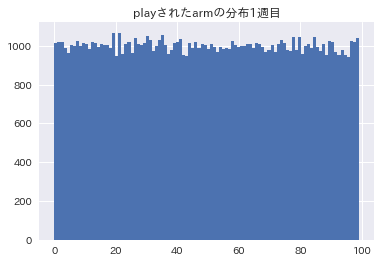

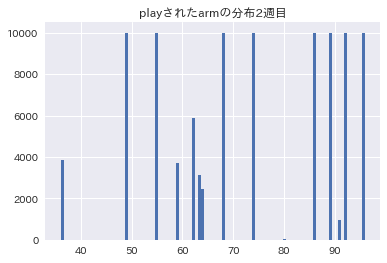

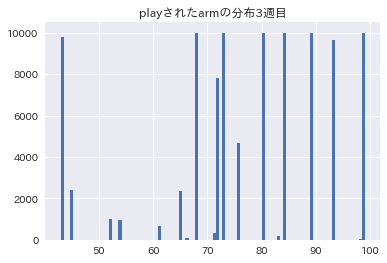

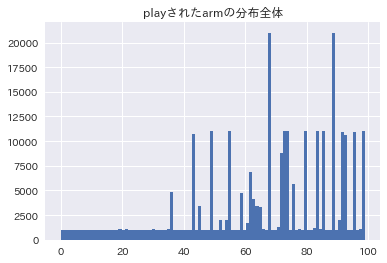

In [47]:
for i in range (3):
    mn = i*10000
    mx = mn+10000
    plt.hist(np.array(history_arm_big[mn:mx]).flatten(),bins=100)
    titles = "playされたarmの分布"+str(i+1)+"週目"
    plt.title(titles)
    plt.show()

plt.hist(np.array(history_arm_big).flatten(),bins=100)
titles = "playされたarmの分布全体"
plt.title(titles)
plt.show()

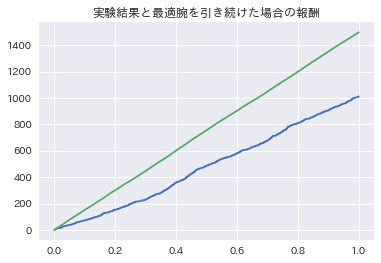

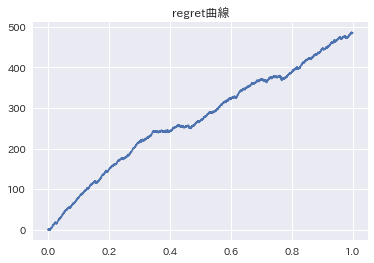

[(68, 20994), (89, 20953), (80, 11063)]


In [46]:
#実験結果
plt.plot(np.linspace(0, 1, len(history_reward_big)),np.cumsum(num_reward_big))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, len(history_reward_big)),np.cumsum(ideal_rewards_big))
plt.title("実験結果と最適腕を引き続けた場合の報酬")
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値(idealと現実の差分)
# regret = (np.zeros(len(history_reward_big))+0.05)-np.array(np.array(history_arm_big).flatten())/2000
regret = np.array(ideal_rewards_big) - np.array(num_reward_big)
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, len(history_reward_big)), cumulative_regret)
plt.title("regret曲線")
plt.show()

#登場回数の多い３位まで
print(Counter(np.array(history_arm_big).flatten()).most_common(3))
#alpha+beta <=1000,超えたら1000の中で按分
#
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1
#同じセッティングで10万イテレーション

In [19]:
#悪くない結果だけど、報酬変えてるつもりないのに１周目から値が変わるのはおかしい